In [1]:
#https://www.kaggle.com/kmader/vgg16-u-net-on-carvana/notebook
#Kevin MaderVGG16+U-Net on Carvana


In [2]:
%matplotlib inline
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import matplotlib.pyplot as plt # plotting
from skimage.io import imread # read in images
from skimage.segmentation import mark_boundaries # mark labels
from sklearn.metrics import roc_curve, auc # roc curve tools
from skimage.color import label2rgb
import numpy as np # linear algebra / matrices
import pandas as pd

from IPython.display import display
from skimage.util.montage import montage2d
from glob import glob
from os.path import split, splitext, join

#base_dir = '/Users/wajdiahmed/Desktop/DS/New_DS/'
base_dir = '/Users/wajdiahmed/Kaggle/Single_Cut/'

In [3]:
all_img_df = pd.DataFrame(dict(path = glob(os.path.join(base_dir, 'images', '*.*'))))
all_img_df['key_id'] = all_img_df['path'].map(lambda x: splitext(os.path.basename(x))[0])
all_img_df['car_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[0])
all_img_df['mask_path'] = all_img_df['path'].map(lambda x: x.replace('images', 'masks').replace('.jpg', '_mask.gif'))
all_img_df['exists'] = all_img_df['mask_path'].map(os.path.exists)
print(all_img_df['exists'].value_counts())
all_img_df.sample(3)

True    47267
Name: exists, dtype: int64


,path,key_id,car_id,mask_path,exists
40406,/Users/wajdiahmed/Kaggle/Single_Cut/images/68f...,68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254...,68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254...,/Users/wajdiahmed/Kaggle/Single_Cut/masks/68f8...,True
39687,/Users/wajdiahmed/Kaggle/Single_Cut/images/TCG...,TCGA-RD-A8N9-01A-01-TS132248,TCGA-RD-A8N9-01A-01-TS132248,/Users/wajdiahmed/Kaggle/Single_Cut/masks/TCGA...,True
5639,/Users/wajdiahmed/Kaggle/Single_Cut/images/TCG...,TCGA-G9-6356-01Z-00-DX144092,TCGA-G9-6356-01Z-00-DX144092,/Users/wajdiahmed/Kaggle/Single_Cut/masks/TCGA...,True


(27, 21, 3) (27, 21)


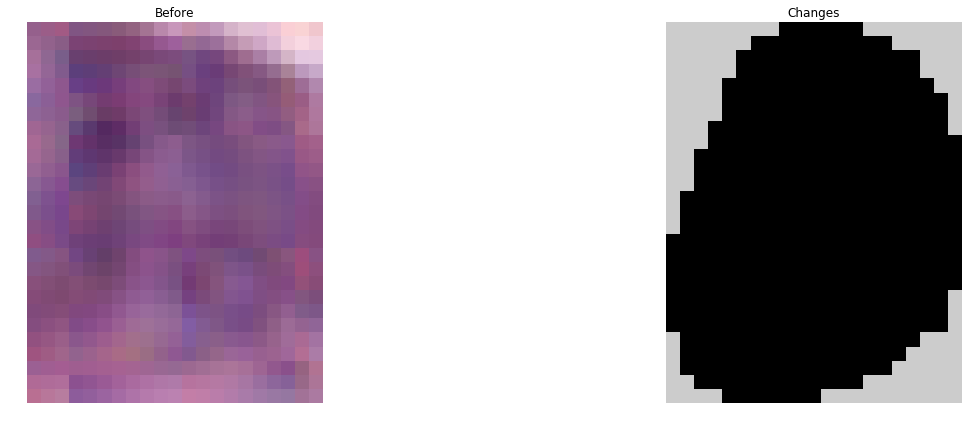

In [4]:
def read_diff_img(c_row):
    t0_img = imread(c_row['path'])[:,:,0:3]
    cg_img = imread(c_row['mask_path'], as_grey=True)
    return (t0_img, cg_img)
def make_change_figure(c_row):
    a,c = read_diff_img(c_row)
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (21,7))
    ax1.imshow(a)
    ax1.set_title('Before')
    ax1.axis('off')
    d = skimage.measure.label(c)
    ax3.imshow(d, cmap = 'nipy_spectral_r')
    ax3.set_title('Changes')
    ax3.axis('off')
    return fig
_, t_row = next(all_img_df.sample(1).iterrows())
make_change_figure(t_row).savefig('overview.png', dpi = 300)
a,c = read_diff_img(t_row)
print(a.shape, c.shape)

In [5]:
from sklearn.model_selection import train_test_split
def train_test_split_on_group(in_df, col_id, **kwargs):
    group_val = np.unique(in_df[col_id])
    train_ids, test_ids = train_test_split(group_val, **kwargs)
    return in_df[in_df[col_id].isin(train_ids)], in_df[in_df[col_id].isin(test_ids)],
train_df, valid_df = train_test_split_on_group(all_img_df, col_id = 'car_id', random_state = 2018, test_size = 0.2)
valid_df, test_df = train_test_split_on_group(valid_df, col_id = 'car_id', random_state = 2018, test_size = 0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')

37813 training images
4727 validation images
4727 test images


In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.01, 
                  height_shift_range = 0.01, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.1],  
                  horizontal_flip = True, 
                  vertical_flip = False, # no upside down cars
                  fill_mode = 'nearest',
                   data_format = 'channels_last',
               preprocessing_function = preprocess_input)
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
default_batch_size = 8
core_idg = ImageDataGenerator(**dg_args)
mask_args = dg_args.copy()
mask_args['preprocessing_function'] = lambda x: x/255.0
mask_idg = ImageDataGenerator(**mask_args)

/Users/wajdiahmed/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/wajdiahmed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [8]:
def make_gen(img_gen, mask_gen, in_df, batch_size = default_batch_size, seed = None, shuffle = True):
    if seed is None:
        seed = np.random.choice(range(9999))
    flow_args = dict(target_size = IMG_SIZE, 
                     batch_size = batch_size, 
                     seed = seed,
                     shuffle = shuffle,
                    y_col = 'key_id')
    t0_gen = flow_from_dataframe(img_gen, in_df, 
                                 path_col = 'path',
                                 color_mode = 'rgb',
                                **flow_args)
    dm_gen = flow_from_dataframe(mask_gen, in_df, 
                                 path_col = 'mask_path',
                                 color_mode = 'grayscale',
                                **flow_args)
    for (t0_img, _), (dm_img, _) in zip(t0_gen, dm_gen):
        yield [t0_img], dm_img

train_gen = make_gen(core_idg, mask_idg, train_df)
valid_gen = make_gen(core_idg, mask_idg, valid_df, seed = 0, shuffle = False)
test_gen = make_gen(core_idg, mask_idg, test_df, seed = 0, shuffle = False, batch_size = 2*default_batch_size)
[t0_img], dm_img = next(train_gen)
print(t0_img.shape, t0_img.max())
print(dm_img.shape, dm_img.max(), dm_img.mean())

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 37813 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 37813 images
(8, 512, 512, 3) 142.061
(8, 512, 512, 1) 1.0 0.7421746


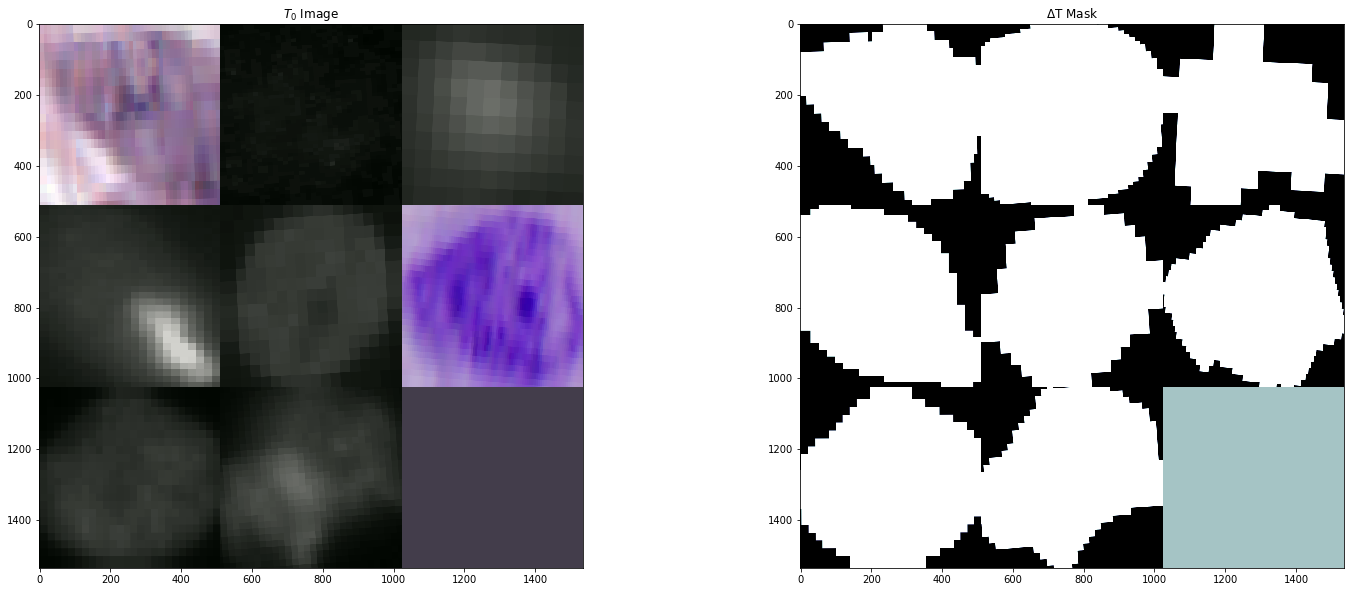

In [9]:
n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
nn_rgb = lambda x: n_rgb(np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1))
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow(nn_rgb(t0_img[:, :, :, :]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage2d(dm_img[:, :, :, 0]), cmap = 'bone')
ax3.set_title('$\Delta$T Mask');

In [10]:
from keras.applications.vgg16 import VGG16 as PTModel
base_pretrained_model = PTModel(input_shape =  t0_img.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
base_pretrained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [11]:
from collections import defaultdict, OrderedDict
from keras.models import Model
layer_size_dict = defaultdict(list)
inputs = []
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs += [c_layer]
# freeze dict
layer_size_dict = OrderedDict(layer_size_dict.items())
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])

(512, 512) ['Conv2D', 'Conv2D']
(256, 256) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(128, 128) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(64, 64) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(32, 32) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(16, 16) ['MaxPooling2D']


In [12]:
%%time
# take the last layer of each shape and make it into an output
pretrained_encoder = Model(inputs = base_pretrained_model.get_input_at(0), 
                           outputs = [v[-1].get_output_at(0) for k, v in layer_size_dict.items()])
pretrained_encoder.trainable = False
n_outputs = pretrained_encoder.predict([t0_img])
for c_out, (k, v) in zip(n_outputs, layer_size_dict.items()):
    print(c_out.shape, 'expected', k)

(8, 512, 512, 64) expected (512, 512)
(8, 256, 256, 128) expected (256, 256)
(8, 128, 128, 256) expected (128, 128)
(8, 64, 64, 512) expected (64, 64)
(8, 32, 32, 512) expected (32, 32)
(8, 16, 16, 512) expected (16, 16)
CPU times: user 1min 8s, sys: 9.77 s, total: 1min 18s
Wall time: 13.3 s


In [13]:
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
x_wid, y_wid = t0_img.shape[1:3]
in_t0 = Input(t0_img.shape[1:], name = 'T0_Image')
wrap_encoder = lambda i_layer: {k: v for k, v in zip(layer_size_dict.keys(), pretrained_encoder(i_layer))}

t0_outputs = wrap_encoder(in_t0)
lay_dims = sorted(t0_outputs.keys(), key = lambda x: x[0])
skip_layers = 2
last_layer = None
for k in lay_dims[skip_layers:]:
    cur_layer = t0_outputs[k]
    channel_count = cur_layer._keras_shape[-1]
    cur_layer = Conv2D(channel_count//2, kernel_size=(3,3), padding = 'same', activation = 'linear')(cur_layer)
    cur_layer = BatchNormalization()(cur_layer) # gotta keep an eye on that internal covariant shift
    cur_layer = Activation('relu')(cur_layer)
    
    if last_layer is None:
        x = cur_layer
    else:
        last_channel_count = last_layer._keras_shape[-1]
        x = Conv2D(last_channel_count//2, kernel_size=(3,3), padding = 'same')(last_layer)
        x = UpSampling2D((2, 2))(x)
        x = concatenate([cur_layer, x])
    last_layer = x
final_output = Conv2D(dm_img.shape[-1], kernel_size=(1,1), padding = 'same', activation = 'sigmoid')(last_layer)
crop_size = 20
final_output = Cropping2D((crop_size, crop_size))(final_output)
final_output = ZeroPadding2D((crop_size, crop_size))(final_output)
unet_model = Model(inputs = [in_t0],
                  outputs = [final_output])
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 512, 512, 64 14714688    T0_Image[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 256)  1179904     model_1[1][3]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 256)  1024        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

unet_model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss=dice_p_bce, 
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
loss_history = []

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/Users/wajdiahmed/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [16]:
loss_history += [unet_model.fit_generator(make_gen(core_idg, mask_idg, train_df), 
                                         steps_per_epoch=min(100, train_df.shape[0]//t0_img.shape[0]), 
                                         epochs = 5, 
                                         validation_data = valid_gen,
                                         validation_steps = 20,
                                         callbacks = callbacks_list,
                                         workers = 2
                                       )]

## Ignore next message from keras, values are replaced anywaysEpoch 1/5

Found 0 images belonging to 0 classes.
Reinserting dataframe: 37813 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 37813 images
 99/100 [============================>.] - ETA: 45s - loss: -0.8592 - dice_coef: 0.8592 - binary_accuracy: 0.7777 - true_positive_rate: 0.9174 ## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4727 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4727 images
100/100 [==============================] - 5051s 51s/step - loss: -0.8594 - dice_coef: 0.8594 - binary_accuracy: 0.7780 - true_positive_rate: 0.9176 - val_loss: -0.8595 - val_dice_coef: 0.8595 - val_binary_accuracy: 0.7788 - val_true_positive_rate: 0.9236

Epoch 00001: val_loss improved from inf 

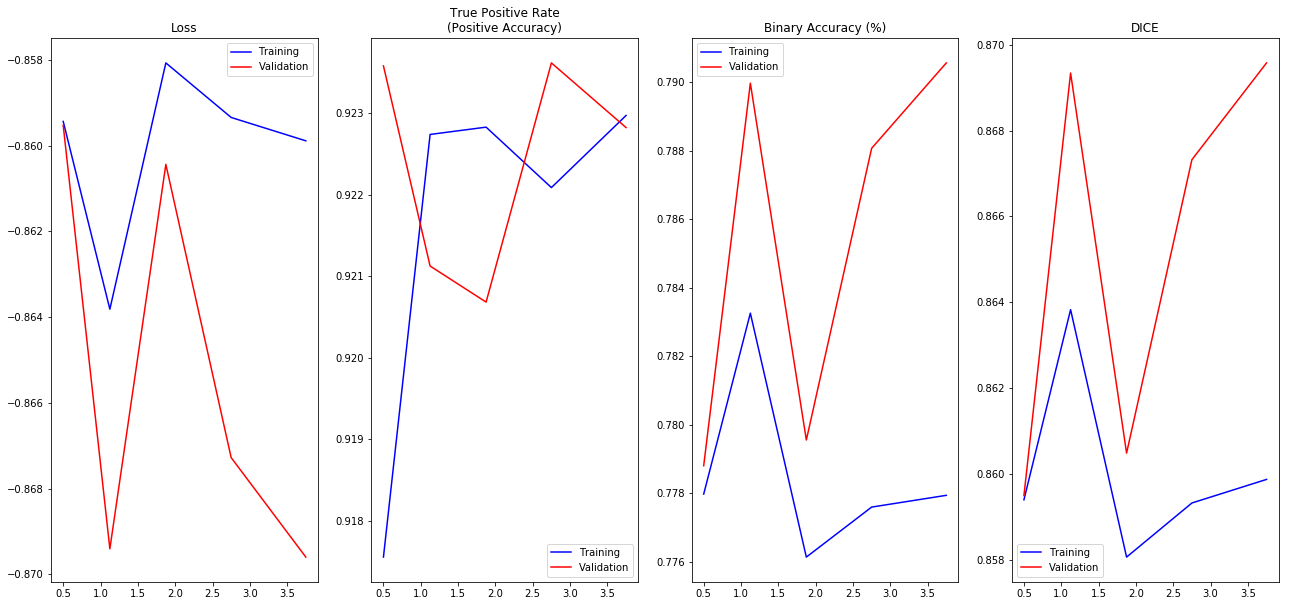

In [17]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [18]:
unet_model.load_weights(weight_path)
unet_model.save('full_seg_model.h5')

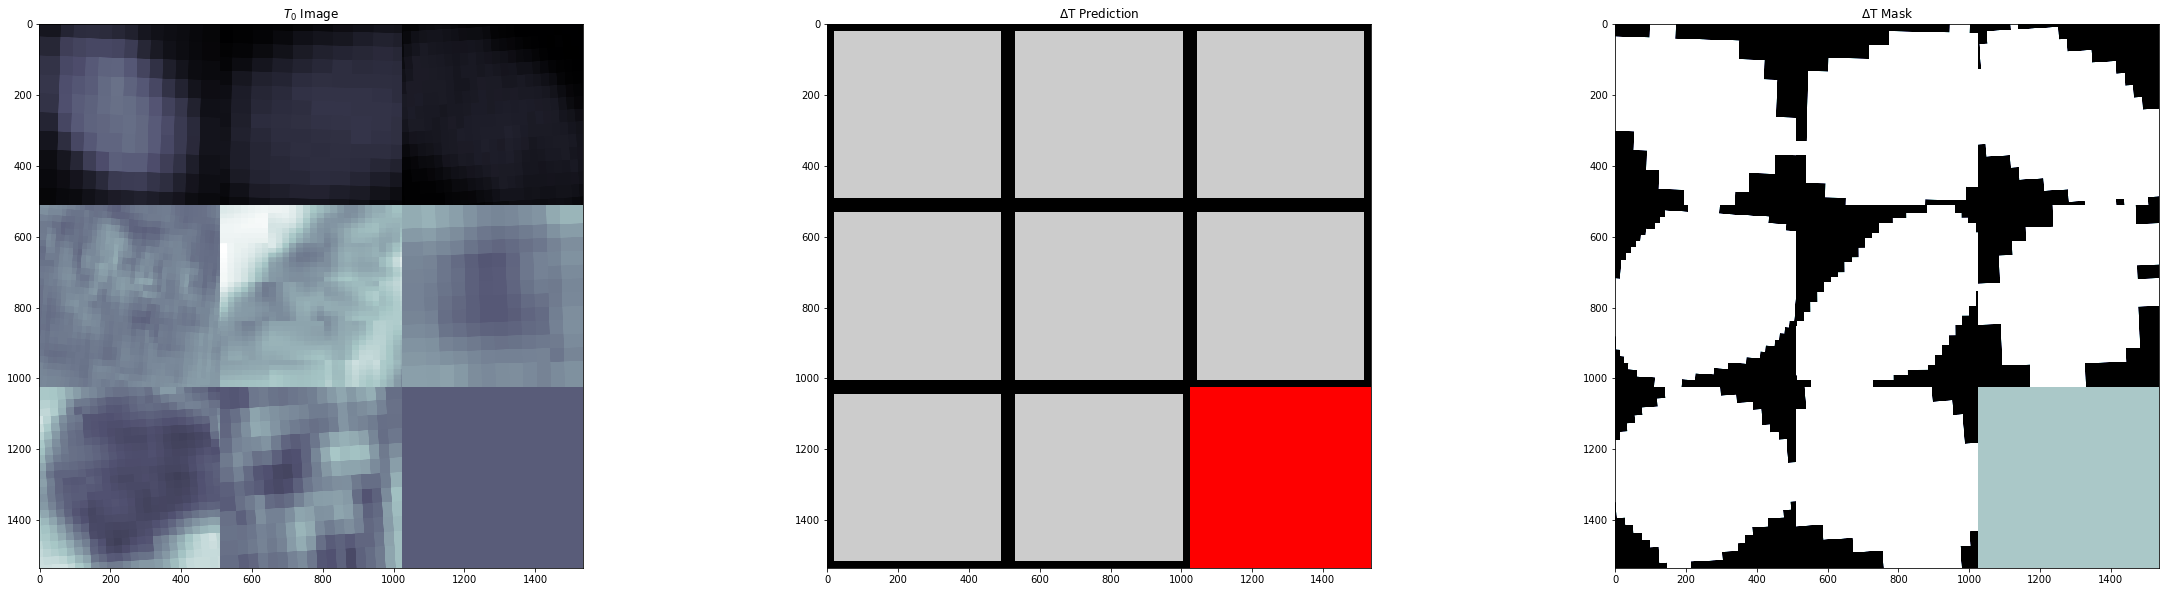

In [19]:
[t0_img], dm_img = next(train_gen)
dm_pred = unet_model.predict([t0_img])
fig, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize = (40, 10))
ax1.imshow(montage2d(t0_img[:, :, :, 0]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage2d(dm_pred[:, :, :, 0]), cmap = 'nipy_spectral')
ax3.set_title('$\Delta$T Prediction');
ax4.imshow(montage2d(dm_img[:, :, :, 0]), cmap = 'bone')
ax4.set_title('$\Delta$T Mask');

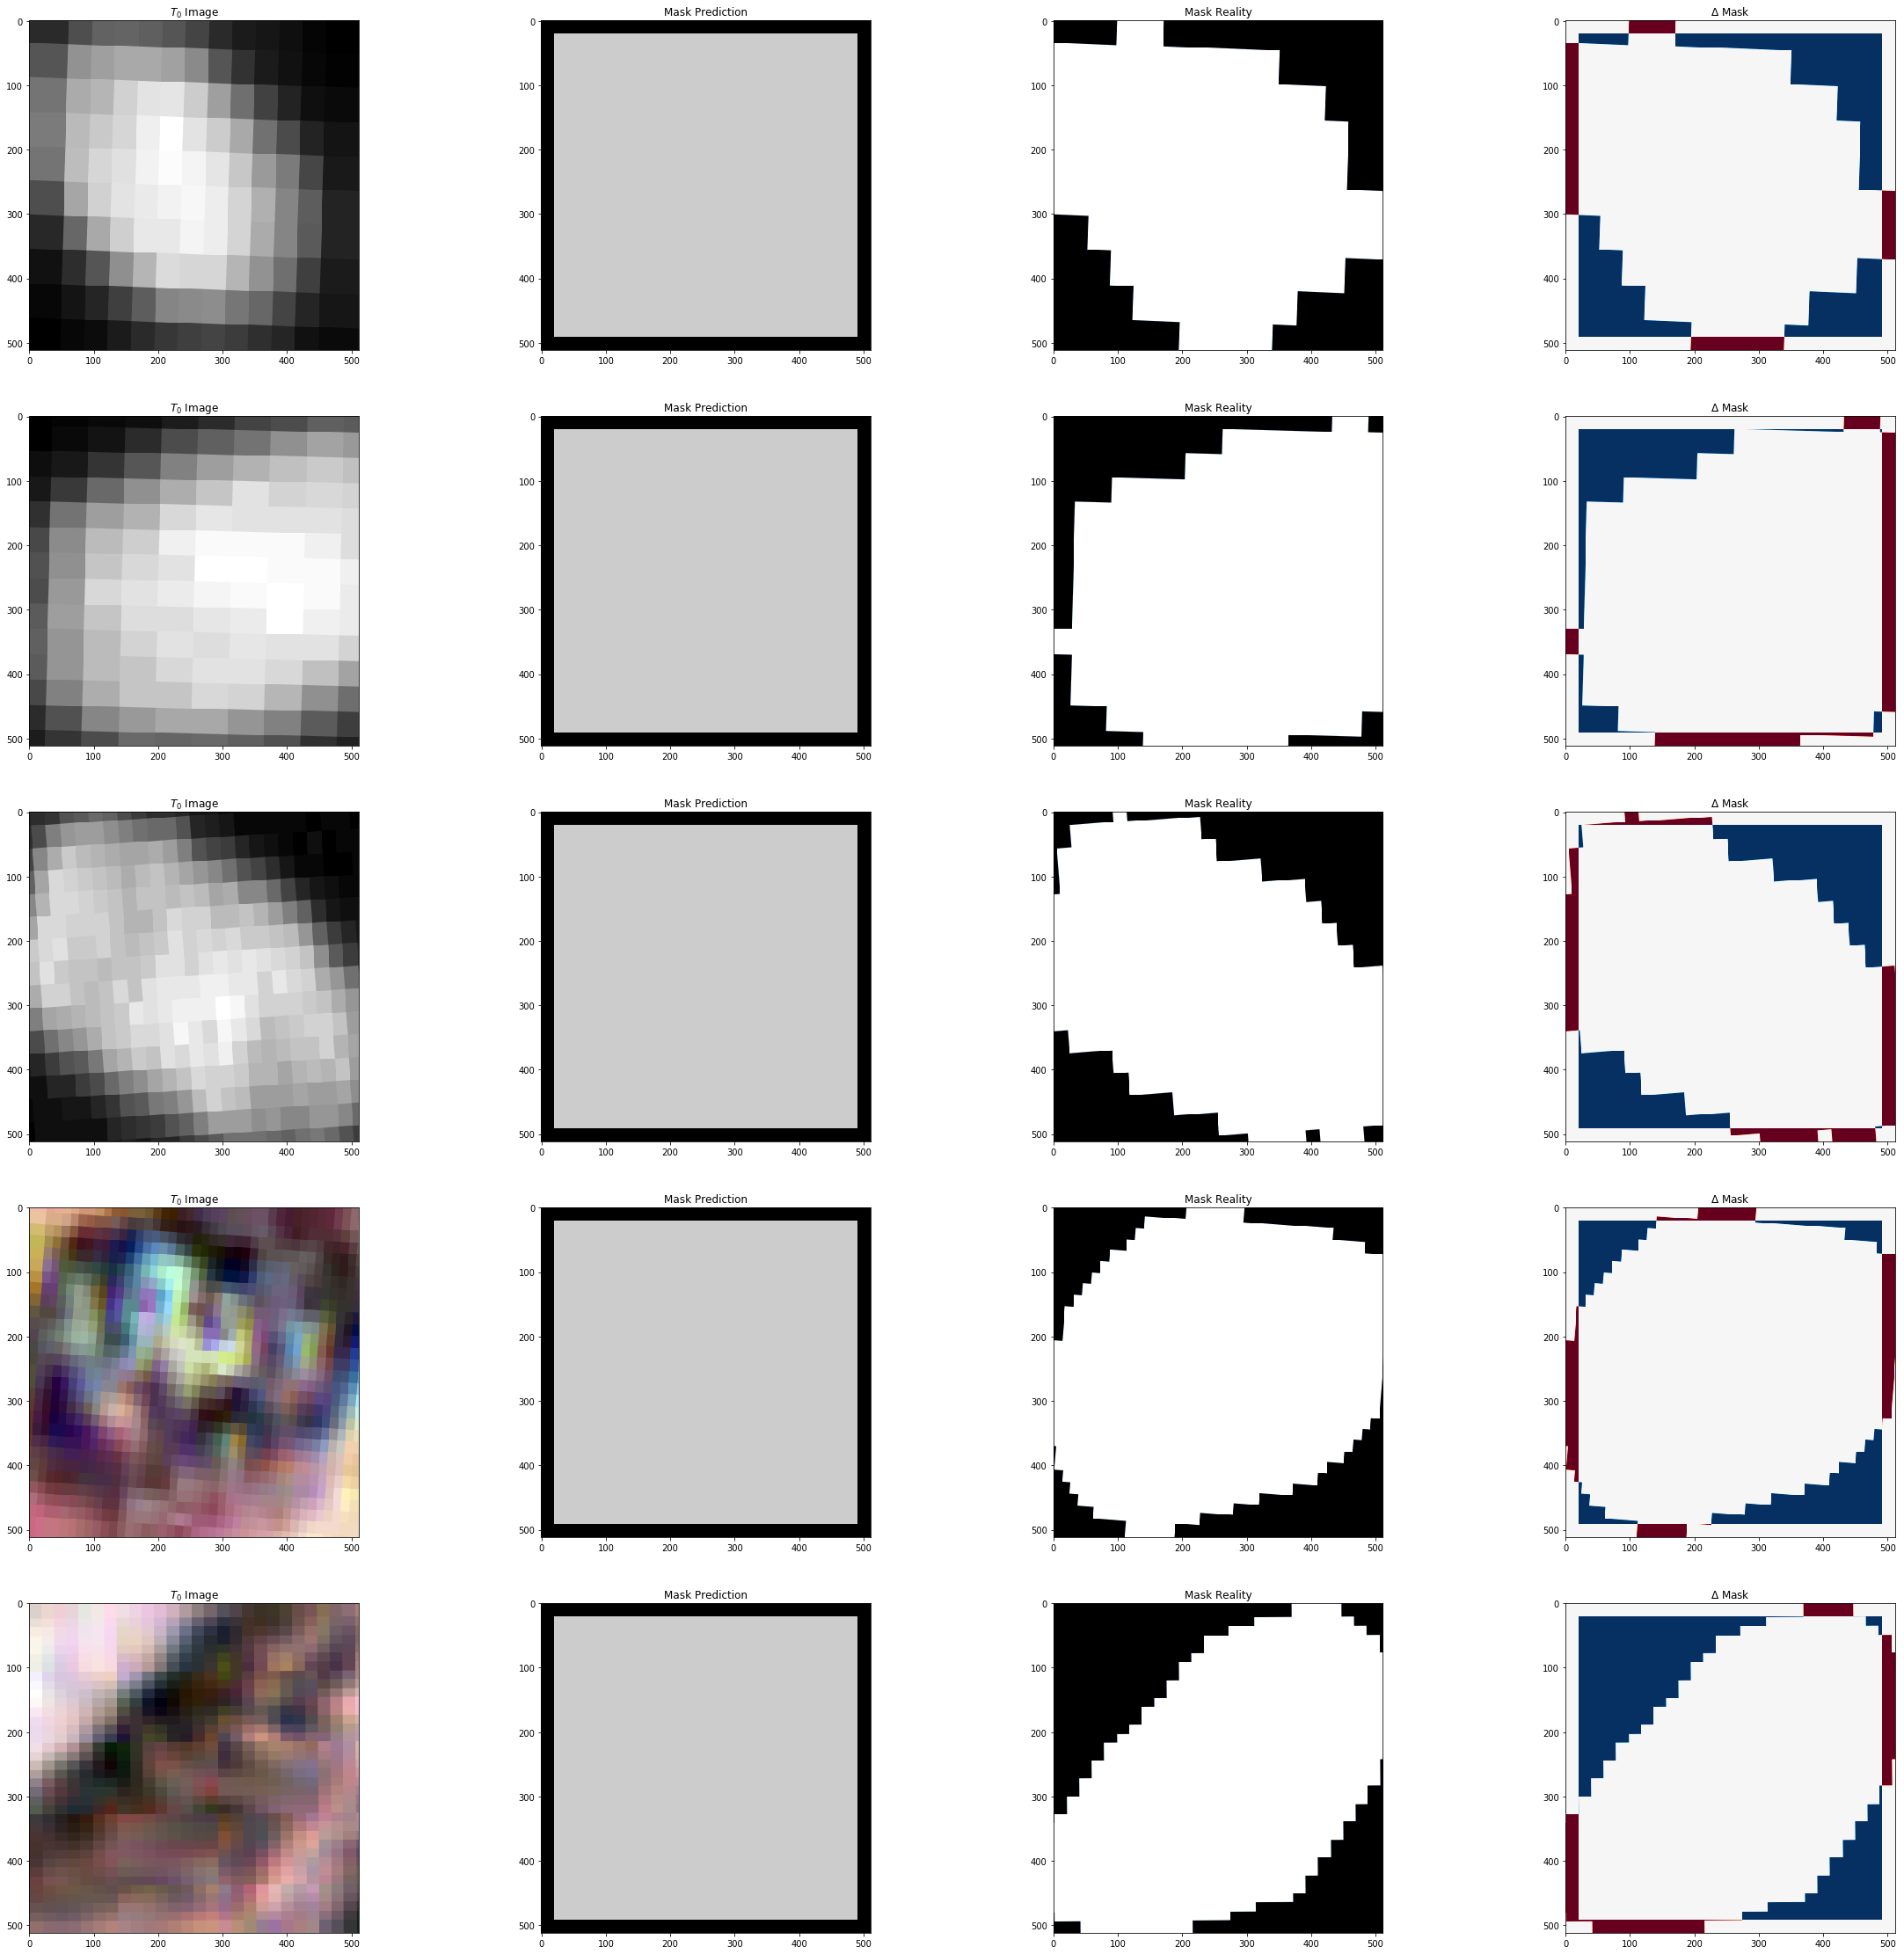

In [ ]:
fig, m_axs = plt.subplots(5, 4, figsize = (40, 40))
for (ax1, ax3, ax4, ax5), x_t0, x_pred, x_dm in zip(m_axs, t0_img, dm_pred, dm_img):
    n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
    ax1.imshow(n_rgb(x_t0), cmap = 'bone')
    ax1.set_title('$T_0$ Image')
    ax3.imshow(x_pred[:, :, 0], cmap = 'nipy_spectral')
    ax3.set_title('Mask Prediction');
    ax4.imshow(x_dm[:, :, 0], cmap = 'bone')
    ax4.set_title('Mask Reality');
    ax5.imshow(x_pred[:, :, 0]-x_dm[:, :, 0], cmap = 'RdBu', vmin = -1, vmax = 1)
    ax5.set_title('$\Delta$ Mask');

In [ ]:
out_parms = unet_model.evaluate_generator(test_gen, steps=test_df.shape[0] // (2*default_batch_size))
print('\n')
for k,v in zip(unet_model.metrics_names, out_parms):
    print(k,'%2.2f' % v)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4727 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4727 images
